<a href="https://colab.research.google.com/github/mohandabdelhalim99/Medical-image-captionninng/blob/main/2_Encoder_Decoder_Architecture.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
Encoder_Weights='/content/drive/MyDrive/ChexNet_weights/brucechou1983_CheXNet_Keras_0.3.0_weights.h5'
Reports_path='/content/drive/MyDrive/Reports/NLMCXR_reports.tgz (Unzipped Files)/ecgen-radiology'
Images_path='/content/drive/MyDrive/Image_captionning/NLMCXR_png.tgz (Unzipped Files)'
DataFrame='/content/drive/MyDrive/GP_DF/Data.csv'

In [ ]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib 
import os
import seaborn as sns
import cv2
import imgaug.augmenters as iaa
sns.set(palette='muted',style='white')
import tensorflow as tf
from tensorflow.keras.layers import Dense,GlobalAveragePooling2D, Input, Embedding, LSTM,Dot,Reshape,Concatenate,BatchNormalization, GlobalMaxPooling2D, Dropout, Add
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from nltk.translate.bleu_score import sentence_bleu #bleu score
tf.compat.v1.enable_eager_execution()
import os
import math
from sklearn.model_selection import train_test_split

In [ ]:
data=pd.read_csv(DataFrame)

In [ ]:
data.head()

,Unnamed: 0,image_1,image_2,comparison,indication,findings,impression,xml file name
0,0,CXR3692_IM-1843-1001.png,CXR3692_IM-1843-2001.png,NaN,chest pain,stable cardiomediastinal silhouette . pulmonar...,no acute cardiopulmonary abnormality .,3692.xml
1,1,CXR3693_IM-1844-1001.png,CXR3693_IM-1844-1002.png,ct of the chest dated,year old woman .,the lungs are clear bilaterally . specifically...,no acute cardiopulmonary abnormality .,3693.xml
2,2,CXR3694_IM-1845-1001.png,CXR3694_IM-1845-2001.png,portable chest hours,year old female chest tube removal .,interval removal of left sided chest tube . sm...,no acute cardiopulmonary abnormality .,3694.xml
3,3,CXR3695_IM-1845-1001.png,CXR3695_IM-1845-2001.png,NaN,shortness of breath,the cardiac silhouette size is at the upper li...,mild central vascular prominence congestion . ...,3695.xml
4,4,CXR3697_IM-1846-1001.png,CXR3697_IM-1846-2001.png,NaN,year old male with,the cardiomediastinal silhouette is stable in ...,no acute cardiopulmonary findings . extensive ...,3697.xml


**Adjust based on impression**

In [ ]:
cols=['image_1','image_2','impression','xml file name']
df_new=data[cols].copy()


###add full path for images
df_new['image_1']=df_new['image_1'].apply(lambda x: os.path.join(Images_path,x))
df_new['image_2']=df_new['image_2'].apply(lambda x: os.path.join(Images_path,x))

###add start and end token for impression
df_new['impression_final']='<CLS> '+df_new['impression']+' <END>'
df_new['impression_input']='<CLS> '+df_new['impression']
df_new['impression_output']=df_new['impression']+' <END>'




In [ ]:
df_new.head(2)

,image_1,image_2,impression,xml file name,impression_final,impression_input,impression_output
0,/content/drive/MyDrive/Image_captionning/NLMCX...,/content/drive/MyDrive/Image_captionning/NLMCX...,no acute cardiopulmonary abnormality .,3692.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>
1,/content/drive/MyDrive/Image_captionning/NLMCX...,/content/drive/MyDrive/Image_captionning/NLMCX...,no acute cardiopulmonary abnormality .,3693.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>


In [ ]:
df_new.impression.value_counts()

no acute cardiopulmonary abnormality .                                                                                                                          383
no acute cardiopulmonary findings .                                                                                                                             172
no acute cardiopulmonary disease .                                                                                                                              147
no acute cardiopulmonary abnormalities .                                                                                                                        141
no active disease .                                                                                                                                             137
                                                                                                                                                               ... 
heart size norma

**Balancing_Data**

In [ ]:
df_new.drop_duplicates(subset = ['xml file name'], inplace = True)

In [ ]:
impression_count=df_new.impression.value_counts()
df_new=df_new.merge(impression_count,left_on='impression',right_index=True)

In [ ]:
df_new.columns = ['impression', 'image_1', 'image_2', 'impression_x', 'xml file name','impression_final',
       'impression_ip', 'impression_op', 'impression_counts'] 
del df_new['impression_x'] 
df_new.head()

,impression,image_1,image_2,xml file name,impression_final,impression_ip,impression_op,impression_counts
0,no acute cardiopulmonary abnormality .,/content/drive/MyDrive/Image_captionning/NLMCX...,/content/drive/MyDrive/Image_captionning/NLMCX...,3692.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367
1,no acute cardiopulmonary abnormality .,/content/drive/MyDrive/Image_captionning/NLMCX...,/content/drive/MyDrive/Image_captionning/NLMCX...,3693.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367
2,no acute cardiopulmonary abnormality .,/content/drive/MyDrive/Image_captionning/NLMCX...,/content/drive/MyDrive/Image_captionning/NLMCX...,3694.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367
6,no acute cardiopulmonary abnormality .,/content/drive/MyDrive/Image_captionning/NLMCX...,/content/drive/MyDrive/Image_captionning/NLMCX...,3698.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367
16,no acute cardiopulmonary abnormality .,/content/drive/MyDrive/Image_captionning/NLMCX...,/content/drive/MyDrive/Image_captionning/NLMCX...,3706.xml,<CLS> no acute cardiopulmonary abnormality . <...,<CLS> no acute cardiopulmonary abnormality .,no acute cardiopulmonary abnormality . <END>,367


In [ ]:
#sanity check
df_new[df_new['impression']=='small bilateral pleural effusions and right infrahilar infiltrate versus bronchovascular crowding .']['impression_counts']

4032    1
Name: impression_counts, dtype: int64

**Split data based on impression count**

In [ ]:
print("impressions that repeated less than 5 times is about {}%".format(len(df_new[df_new['impression_counts']<5])*100/df_new.shape[0]))

impressions that repeated less than 5 times is about 46.2565445026178%


In [ ]:
data_more_than_5=df_new[df_new['impression_counts']>5]
data_less_than_5=df_new[df_new['impression_counts']<5]
#####################################################################
train_more,test_more=train_test_split(data_more_than_5,test_size=0.2,stratify=data_more_than_5['impression'],random_state=1)
test_less=data_less_than_5.sample(int(0.2*len(data_less_than_5)))
data_less_than_5=data_less_than_5.drop(test_less.index,axis=0)
####################################################################
test=test_more.append(test_less)
test=test.reset_index(drop=True)
###################################################################
train=train_more.append(data_less_than_5)
train=train.reset_index(drop=True)

In [ ]:
train.shape[0],test.shape[0]

(3024, 756)

In [ ]:
from sklearn.utils import resample

df_majority=train[train['impression_counts']>=100]
print("majority count is {}".format(df_majority.shape[0]))

df_minority=train[train['impression_counts']<=5]
print("minority count is {}".format(df_minority.shape[0]))


df_other=train[(train['impression_counts']>5) &  (train['impression_counts']<100)]
print("other count is {}".format(df_other.shape[0]))

majority count is 830
minority count is 1414
other count is 780


In [ ]:
n1=df_minority.shape[0]
n2=df_majority.shape[0]
n3=df_other.shape[0]

In [ ]:
df_minority_upsampled = resample(df_minority,
                                 replace = True,
                                 n_samples = 3*n1,
                                 random_state = 420)
df_majority_downsampled = resample(df_majority,
                                 replace = False,
                                 n_samples = n2//15,
                                 random_state = 420)
df_other_downsampled = resample(df_other,
                                 replace = False,
                                 n_samples = n3//10,
                                 random_state = 420)

train = pd.concat([df_majority_downsampled ,df_minority_upsampled,df_other_downsampled])
train = train.reset_index(drop=True)
# del df_minority_upsampled,df_minority,df_majority,df_other,df_other_downsampled
train.shape

(4375, 8)

In [ ]:
train.impression.value_counts()

no acute cardiopulmonary abnormality .                                                                                                                                                                                           18
small bilateral pleural effusions .                                                                                                                                                                                              15
unremarkable radiographs of the chest .                                                                                                                                                                                          15
stable cardiomegaly without acute cardiopulmonary abnormality .                                                                                                                                                                  15
hypoinflation with no visible active cardiopulmonary disease .                          

In [ ]:
train.to_csv('train.csv')
test.to_csv('test.csv')

**Tokenizer**

In [ ]:
tokenizer=Tokenizer(filters='',oov_token='<oov>')
tokenizer.fit_on_texts(train.impression_final)
train_seq=tokenizer.texts_to_sequences(train.impression_final)
test_seq=tokenizer.texts_to_sequences(test.impression_final)
vocab_size=len(tokenizer.word_index)
lens=[len(i) for i in train_seq]
start_index=tokenizer.word_index['<cls>']
end_index=tokenizer.word_index['<end>']


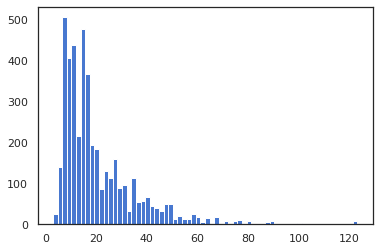

In [ ]:
plt.hist(lens,bins=int(np.sqrt(len(train_seq))));

In [ ]:
max_pad=80
batch_siz=20
embedding_dim=300

**Data Loader**

In [ ]:
class Dataset():
 
  def __init__(self,df,input_size,tokenizer = tokenizer, augmentation = True,max_pad = max_pad): 
    """
    df  = dataframe containing image_1,image_2 and impression
    """
    self.image1 = df.image_1
    self.image2 = df.image_2
    self.caption = df.impression_ip #inp
    self.caption1 = df.impression_op  #output
    self.input_size = input_size 
    self.tokenizer = tokenizer
    self.augmentation = augmentation
    self.max_pad = max_pad

 
    self.aug1 = iaa.Fliplr(1) 
    self.aug2 = iaa.Flipud(1) 


  def __getitem__(self,i):
    
    image1 = cv2.imread(self.image1[i],cv2.IMREAD_UNCHANGED)/255 
    image2 = cv2.imread(self.image2[i],cv2.IMREAD_UNCHANGED)/255
    image1 = cv2.resize(image1,self.input_size,interpolation = cv2.INTER_NEAREST)
    image2 = cv2.resize(image2,self.input_size,interpolation = cv2.INTER_NEAREST)
  



    if self.augmentation: 
            a = np.random.uniform()
            if a<0.333:
                image1 = self.aug1.augment_image(image1)
                image2 = self.aug1.augment_image(image2)
            elif a<0.667:
                image1 = self.aug2.augment_image(image1)
                image2 = self.aug2.augment_image(image2)
            else: 
              pass;


    caption = self.tokenizer.texts_to_sequences(self.caption[i:i+1]) 

    caption = pad_sequences(caption,maxlen = self.max_pad,padding = 'post') 
    caption = tf.squeeze(caption,axis=0)

    caption1 = self.tokenizer.texts_to_sequences(self.caption1[i:i+1]) 

    caption1 = pad_sequences(caption1,maxlen = self.max_pad,padding = 'post') 
    caption1 = tf.squeeze(caption1,axis=0) 




    
    
    return image1,image2,caption,caption1

    
  def __len__(self):
    return len(self.image1)


class Dataloader(tf.keras.utils.Sequence):     
    def __init__(self, dataset, batch_size=1, shuffle=True):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(self.dataset))

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        indexes = [self.indexes[j] for j in range(start,stop)] 
        data = [self.dataset[j] for j in indexes] 
        
        batch = [np.stack(samples, axis=0) for samples in zip(*data)] 
                                                                      


        return tuple([[batch[0],batch[1],batch[2]],batch[3]]) 
    
    def __len__(self): 
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self): 
        if self.shuffle:
            np.random.shuffle(self.indexes) 

In [ ]:
input_size = (224,224)
train_dataloader = Dataset(train,input_size)
train_dataloader = Dataloader(train_dataloader,batch_size = batch_siz)

test_dataloader = Dataset(test,input_size)
test_dataloader = Dataloader(test_dataloader,batch_size = batch_siz)

**CHeXNET**

In [ ]:
def Encoder_chexnet(ChexNet_weights=Encoder_Weights):

  model=tf.keras.applications.DenseNet121(include_top=False)
  x=model.output
  x=GlobalAveragePooling2D()(x)
  x=Dense(14,activation='sigmoid')(x)

  chexnet=tf.keras.Model(inputs=model.input,outputs=x)
  chexnet.load_weights(ChexNet_weights)
  chexnet=tf.keras.Model(inputs=model.input,outputs=chexnet.layers[-2].output)
  #take feature map not output  ##and op too

  return chexnet

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.692339 to fit



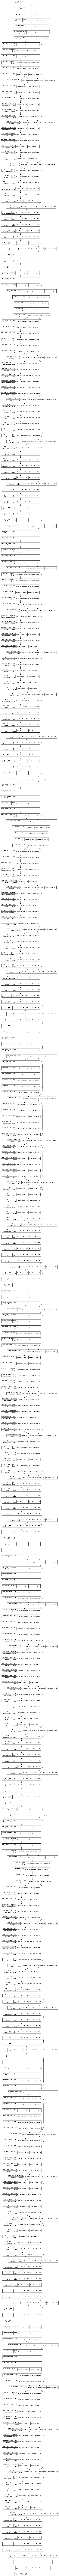

In [ ]:
chexnet=Encoder_chexnet()
chexnet.trainable=False

tf.keras.utils.plot_model(
    chexnet,
    to_file="model_1.png",
    show_shapes=True,
)

**Encoder**

In [ ]:
class Image_encoder(tf.keras.layers.Layer):
  """
  This layer will output image backbone features after passing it through chexnet
  here chexnet will be not be trainable
  """
  def __init__(self,
               name = "image_encoder_block"
               ):
    super().__init__()
    self.chexnet = Encoder_chexnet()
    self.chexnet.trainable = False
    # for i in range(10): #the last 10 layers of chexnet will be trained
    #   self.chexnet.layers[-i].trainable = True
    
  def call(self,data):
    op = self.chexnet(data)
    return op

**Decoder**

In [ ]:
import spacy
! python -m spacy download en_core_web_md
nlp = spacy.load('en_core_web_md')

In [ ]:
embedding_matrix=np.zeros((vocab_size+1,300))
for word ,j in tokenizer.word_index.items():
  for i,doc in enumerate(nlp.pipe(word)):
     embedding_matrix[i]=doc.vector

In [ ]:
embedding_matrix.shape

In [ ]:
tf.keras.backend.clear_session()
image1=Input((224,224,3,))
image2=Input((224,224,3,))
caption=Input(shape=(max_pad,))

img_encoder=Image_encoder()

fm1=img_encoder(image1)
fm2=img_encoder(image2)

fm_final=Concatenate(axis=-1)([fm1,fm2])




image_dense=Dense(512,activation='relu',name='image_dense',use_bias=False) #why use bias false
image_backone=image_dense(fm_final)
image_dense_op = tf.keras.backend.expand_dims(image_backone,axis=1) 

embedding=Embedding(input_dim=vocab_size+1,
                    output_dim=embedding_dim,
                    input_length=max_pad,
                    mask_zero=True,
                    weights=[embedding_matrix])

embedding_op=embedding(caption)

lstm_layer = LSTM(units = 512,
                  return_sequences= True,
                  return_state = True     
                  )
lstm_op,lstm_h,lstm_c = lstm_layer(embedding_op,initial_state = [image_backone,image_backone]) #op_shape = batch_size*input_length*lstm_units


add = Add()([image_dense_op,lstm_op])

op_dense = Dense(vocab_size+1,
                 activation = 'softmax',
                 name = 'output_dense'
                 ) #op: (?,input_length,vocab_size+1)

output = op_dense(add)

model = tf.keras.Model(inputs = [image1,image2,caption], outputs = output)


In [ ]:
model.summary()

In [ ]:
tf.keras.utils.plot_model(model,
                          show_shapes = True
                          )

In [ ]:
loss_func = tf.keras.losses.SparseCategoricalCrossentropy() 

def custom_loss(y_true, y_pred):
    #getting mask value to not consider those words which are not present in the true caption
    mask = tf.math.logical_not(tf.math.equal(y_true, 0))

    #y_pred = y_pred+10**-7 #to prevent loss becoming null

    #calculating the loss
    loss_ = loss_func(y_true, y_pred)
    
    #converting mask dtype to loss_ dtype
    mask = tf.cast(mask, dtype=loss_.dtype)
    
    #applying the mask to loss
    loss_ = loss_*mask
    
    #returning mean over all the values
    return tf.reduce_mean(loss_)

lr = 10**-3
optimizer = tf.keras.optimizers.Adam(learning_rate = lr)   
model.compile(optimizer=optimizer,loss=custom_loss,metrics= ['accuracy'])

In [ ]:
model.fit(train_dataloader,
          validation_data = test_dataloader,
          epochs = 10,
          callbacks = my_callbacks
          )